In [2]:
from __future__ import print_function, division
import os
import sys
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import math
import itertools
import pickle
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
from itertools import groupby
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
print(torch.__version__)
import torchmetrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

2.2.2


In [6]:
df = pd.read_pickle("/Users/jackmcmahon/Development/CHEM 101.6/residence_time_prediction/lig47_hbonds_dict")

In [99]:
print(len(df.keys()))
print(df.keys())

for key in df.keys():
  print(key)
  print(df[key]['atoms'])
  
df1 = df['TYR133']

print(df1.keys())
print(df1['atoms'])
print(df1['distances'])
print(df1['distances'].shape)

# (donor atom number) (hydrogen atom number) (acceptor atom number (on ligand for all except))

# h bond cutoff of 0.35 nm Baker Hubbard

# still predict overall residence time

# ---------------------------------
# hydrophobic
# ()

21
dict_keys(['ASP121', 'ASN122', 'GLU123', 'ALA124', 'TYR125', 'GLU126', 'MET127', 'PRO128', 'SER129', 'GLU130', 'GLU131', 'GLY132', 'TYR133', 'GLN134', 'ASP135', 'TYR136', 'GLU137', 'PRO138', 'GLU139', 'ALA140', '<1>1'])
ASP121
[[  0   8 299]
 [  0   8 300]
 [  0   8 316]
 [  0   8 317]
 [  0   8 318]
 [  0   8 319]
 [  0   8 329]]
ASN122
[[ 12  20 329]
 [ 12  20 319]
 [ 12  20 318]
 [ 12  20 316]
 [ 12  20 300]
 [ 12  20 299]
 [ 12  20 317]
 [ 19  25 300]
 [ 19  25 319]
 [ 19  25 318]
 [ 19  25 317]
 [ 19  25 316]
 [ 19  25 299]
 [ 19  25 329]
 [ 19  24 319]
 [ 19  24 299]
 [ 19  24 300]
 [ 19  24 329]
 [ 19  24 317]
 [ 19  24 318]
 [ 19  24 316]]
GLU123
[[ 26  35 299]
 [ 26  35 316]
 [ 26  35 317]
 [ 26  35 318]
 [ 26  35 319]
 [ 26  35 329]
 [ 26  35 300]]
ALA124
[[ 41  46 329]
 [ 41  46 318]
 [ 41  46 319]
 [ 41  46 316]
 [ 41  46 300]
 [ 41  46 299]
 [ 41  46 317]]
TYR125
[[ 51  63 299]
 [ 51  63 300]
 [ 51  63 316]
 [ 51  63 317]
 [ 51  63 318]
 [ 51  63 319]
 [ 51  63 329]
 [ 

In [7]:
frames = [df[key]['distances'] for key in df.keys()]
combined = np.concatenate(frames, axis=1)
print(combined.shape)

(1100889, 314)


In [8]:
dfaro = np.load("/Users/jackmcmahon/Development/CHEM 101.6/residence_time_prediction/aro_contacts.npy")

(1100889, 3)
[0. 0. 0. ... 0. 0. 0.]


(array([946393.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
        154496.]),
 array([0.        , 0.04545455, 0.09090909, 0.13636364, 0.18181818,
        0.22727273, 0.27272727, 0.31818182, 0.36363636, 0.40909091,
        0.45454545, 0.5       , 0.54545455, 0.59090909, 0.63636364,
        0.68181818, 0.72727273, 0.77272727, 0.81818182, 0.86363636,
        0.90909091, 0.95454545, 1.        ]),
 <BarContainer object of 22 artists>)

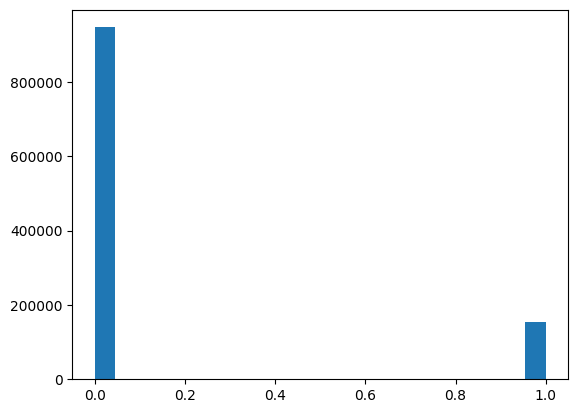

In [101]:
print(dfaro.shape)

print(dfaro[:,0])

plt.hist(dfaro[:,0], bins='auto')


In [9]:
dcharges = np.load("/Users/jackmcmahon/Development/CHEM 101.6/residence_time_prediction/charge_dist_matrix.npy")
print(dcharges.shape)

(1100889, 9)


In [3]:
dmat = np.load("distance_matrix_full_LIG.npy")
print(dmat.shape)

def combined_residence_events(data):
  idx = np.arange(len(data[:,0]))
  
  bool = np.where(data<.6,1,0)
  any_event_residue = np.any(bool, axis=1)
  
  comp = np.stack([idx,any_event_residue],axis = 1)
  return [i[:,0][1:] if len(i)>1 else i[:,0] for i in filter(lambda x:any(x[:,1]!=0),np.split(comp,np.where(comp[:,1]==0)[0]))]

(1100889, 20)


In [4]:
# inputs = torch.from_numpy(std_avg)
# inputs = torch.tensor(inputs, dtype=torch.float32)
# print(inputs.shape)
# print(inputs)
# targets= torch.from_numpy(np.reshape(logmapping, (logmapping.shape[0],1)))
# targets = torch.tensor(targets, dtype=torch.float32)
# print(targets.shape)
# print(targets)
# dataset = TensorDataset(inputs, targets)

# N = dmat.shape[0]
N = 11279
indices = np.arange(N)
# indices = np.random.permutation(indices)
train_indices = indices[:int(0.7*N)]
val_indices = indices[int(0.7*N):int(0.8*N)]
test_indices = indices[int(0.8*N):int(1*N)]

print(len(train_indices))
print(train_indices)
train_len = len(train_indices)
print(len(val_indices))
print(val_indices)
val_len = len(val_indices)
print(len(test_indices))
print(test_indices)
test_len = len(test_indices)

7895
[   0    1    2 ... 7892 7893 7894]
1128
[7895 7896 7897 ... 9020 9021 9022]
2256
[ 9023  9024  9025 ... 11276 11277 11278]


In [10]:
events_all = combined_residence_events(dmat)
mapping_all = np.zeros(len(events_all))
avg_all = np.zeros([len(events_all), len(dmat[0,:])])
mapping_5_476 = np.zeros(len(events_all))
avg_5_476 = np.zeros([len(events_all), len(dmat[0,:])])
mapping_25_476 = np.zeros(len(events_all))
avg_25_476 = np.zeros([len(events_all), len(dmat[0,:])])


avg_hbond_all = np.zeros([len(events_all), len(combined[0,:])])
avg_aro_all = np.zeros([len(events_all), len(dfaro[0,:])])
avg_charges_all = np.zeros([len(events_all), len(dcharges[0,:])])

# avg_all is all events
# avg_5_476 is middle range
# avg_25_476 is narrowest range

count = 0
for event in events_all:
  mapping_all[count] = len(event)
  avg_all[count] = np.mean(dmat[event[0]:event[-1]+1], axis=0)
  avg_hbond_all[count] = np.mean(combined[event[0]:event[-1]+1], axis=0)
  avg_aro_all[count] = np.mean(dfaro[event[0]:event[-1]+1], axis=0)
  avg_charges_all[count] = np.mean(dcharges[event[0]:event[-1]+1], axis=0)
  count += 1
  
# avg_new = np.concatenate([avg_all,avg_hbond_all, avg_aro_all, avg_charges_all], axis=1)
avg_new = np.concatenate([avg_all], axis=1)

# stats
sortevents = np.sort(np.array([len(i) for i in events_all]))[::-1]
print("Longest five events:", sortevents[:5])


# Getting different ranges
mapping_5_476 = mapping_all[mapping_all > 4]
avg_5_476 = avg_new[mapping_all > 4]
avg_5_476 = avg_5_476[mapping_5_476 < 477]
mapping_5_476 = mapping_5_476[mapping_5_476 < 477]

mapping_25_476 = mapping_all[mapping_all > 24]
avg_25_476 = avg_new[mapping_all > 24]
avg_25_476 = avg_25_476[mapping_25_476 < 477]
mapping_25_476 = mapping_25_476[mapping_25_476 < 477]

print("Total events:", len(mapping_all))
print("With avg distance input data of shape:", avg_new.shape)

print("Events between 5 and 476 frames:", len(mapping_5_476))
print("With avg distance in put data of shape:", avg_5_476.shape)

print("Events between 25 and 476 frames:", len(mapping_25_476))
print("With avg distance input data of shape:", avg_25_476.shape)


Longest five events: [12021  7432  5990  4327  3629]
Total events: 32264
With avg distance input data of shape: (32264, 20)
Events between 5 and 476 frames: 11279
With avg distance in put data of shape: (11279, 20)
Events between 25 and 476 frames: 4589
With avg distance input data of shape: (4589, 20)


In [11]:
mapping = mapping_all
avg = avg_new


In [12]:
print("max length:", np.max(mapping))
print("min length:", np.min(mapping))
# logmapping =  np.log(mapping)
logmapping = mapping/100
print("max log length:",np.max(logmapping))
print("min log length:",np.min(logmapping))

amean = np.mean(avg, 0)
print("mean:", amean)
astd = np.std(avg, 0)
print("std deviation:", astd)

std_avg = (avg - amean)/astd

print("standardized avg distance data")

max length: 12021.0
min length: 1.0
max log length: 120.21
min log length: 0.01
mean: [1.45652661 1.42421257 1.38172276 1.44046781 1.33266462 1.35720402
 1.35195526 1.38690613 1.38588823 1.33485526 1.32987891 1.4034782
 1.28932623 1.30673398 1.32943799 1.26828554 1.2911307  1.35255405
 1.30806721 1.3861965 ]
std deviation: [0.5443374  0.53097404 0.55025525 0.52478114 0.50648978 0.51083706
 0.49258866 0.49523559 0.50256003 0.53488036 0.53438777 0.50337883
 0.49026523 0.48072664 0.49756007 0.49304512 0.52472687 0.53718686
 0.57053443 0.58603816]
standardized avg distance data


In [13]:
a1 = std_avg[train_indices]
m1 = logmapping[train_indices]
a2 = std_avg[val_indices]
m2 = logmapping[val_indices]
a3 = std_avg[test_indices]
m3 = logmapping[test_indices]
print(a1.shape)

(7895, 20)


In [14]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
clf = TabNetRegressor()
clf.fit(
  a1, m1.reshape(-1, 1),
  eval_set=[(a2, m2.reshape(-1, 1))], max_epochs=80
)

/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 5.38849 | val_0_mse: 0.93577 |  0:00:00s
epoch 1  | loss: 4.31211 | val_0_mse: 0.86109 |  0:00:01s
epoch 2  | loss: 4.08762 | val_0_mse: 0.7712  |  0:00:02s
epoch 3  | loss: 3.93747 | val_0_mse: 0.94546 |  0:00:03s
epoch 4  | loss: 3.73165 | val_0_mse: 0.62998 |  0:00:03s
epoch 5  | loss: 3.80804 | val_0_mse: 0.6606  |  0:00:04s
epoch 6  | loss: 3.31836 | val_0_mse: 0.55464 |  0:00:05s
epoch 7  | loss: 3.71359 | val_0_mse: 0.63806 |  0:00:06s
epoch 8  | loss: 1.73606 | val_0_mse: 0.83546 |  0:00:07s
epoch 9  | loss: 3.58127 | val_0_mse: 0.72124 |  0:00:08s
epoch 10 | loss: 3.5641  | val_0_mse: 0.74546 |  0:00:09s
epoch 11 | loss: 3.68854 | val_0_mse: 0.64696 |  0:00:11s
epoch 12 | loss: 3.74932 | val_0_mse: 0.63577 |  0:00:11s
epoch 13 | loss: 3.76671 | val_0_mse: 0.59208 |  0:00:12s
epoch 14 | loss: 3.56602 | val_0_mse: 0.65423 |  0:00:13s
epoch 15 | loss: 1.73824 | val_0_mse: 0.65016 |  0:00:13s
epoch 16 | loss: 3.73458 | val_0_mse: 0.65369 |  0:00:14s

Early stoppin

/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [15]:
preds = clf.predict(a3)
preds = preds[:,0]

In [16]:
print(preds)
print(m3)

ap2 = preds*100
al2 = m3*100

print(np.mean(ap2))
print(np.mean(al2))

[-0.05638655  0.01130791  0.43049482 ...  0.02483051  0.02162188
  0.13754049]
[0.01 0.34 0.01 ... 0.05 0.24 1.26]
35.216084
25.85328014184397


In [17]:
top = (-al2).argsort(axis=0)[:10]
for index in top:
  print("predicted", ap2[index], "real:", al2[index])
  
print("")
  
top = (-ap2).argsort(axis=0)[:10]
for index in top:
  print("predicted", ap2[index], "real:", al2[index])
  
print("")
  
bottom = (ap2).argsort(axis=0)[:10]
for index in bottom:
  print("predicted", ap2[index], "real:", al2[index])

predicted 943.7056 real: 2032.0
predicted 560.96857 real: 1230.0
predicted 363.89334 real: 1205.0
predicted 831.80914 real: 1158.0
predicted 150.51889 real: 841.0
predicted 262.38745 real: 808.0
predicted 319.62775 real: 764.0
predicted 196.1606 real: 728.0
predicted 282.58856 real: 704.0
predicted 306.66104 real: 689.0

predicted 943.7056 real: 2032.0
predicted 937.5699 real: 329.0
predicted 903.7077 real: 447.0
predicted 880.8016 real: 400.0
predicted 860.3407 real: 283.0
predicted 831.80914 real: 1158.0
predicted 796.67395 real: 401.99999999999994
predicted 747.58813 real: 141.0
predicted 709.5628 real: 530.0
predicted 672.35986 real: 420.0

predicted -32.451057 real: 2.0
predicted -31.306536 real: 1.0
predicted -28.771854 real: 3.0
predicted -25.78594 real: 1.0
predicted -24.857006 real: 2.0
predicted -24.616737 real: 1.0
predicted -22.715673 real: 17.0
predicted -22.278366 real: 7.000000000000001
predicted -21.066162 real: 1.0
predicted -20.573353 real: 1.0


r2: 0.6814018447057919


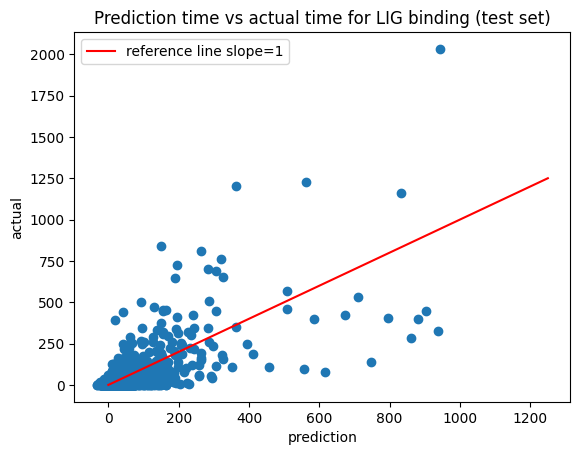

In [19]:
plt.scatter(ap2,al2)
# r=np.corrcoef(ap2[:,0], al2[:,0])
r=np.corrcoef(ap2, al2)
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 1250,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("Prediction time vs actual time for LIG binding (test set)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.show()

#whole dataset, just distance data, averages

r2: 0.7701109156030733


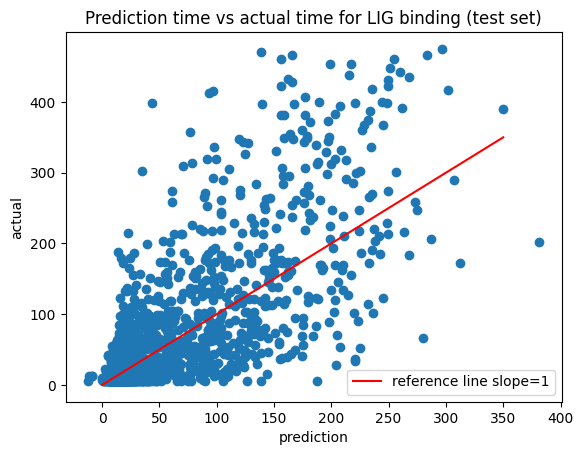

In [241]:
plt.scatter(ap2,al2)
# r=np.corrcoef(ap2[:,0], al2[:,0])
r=np.corrcoef(ap2, al2)
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 350,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("Prediction time vs actual time for LIG binding (test set)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.show()

#just distances averages

r2: 0.6919687910556457


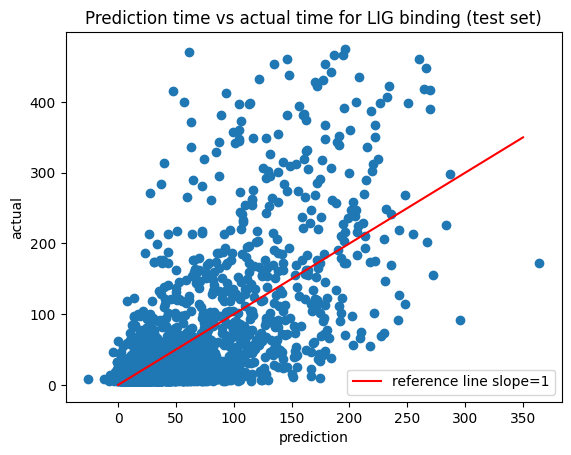

In [250]:
plt.scatter(ap2,al2)
# r=np.corrcoef(ap2[:,0], al2[:,0])
r=np.corrcoef(ap2, al2)
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 350,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("Prediction time vs actual time for LIG binding (test set)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.show()

#just h bonds averages

r2: 0.6592815556305677


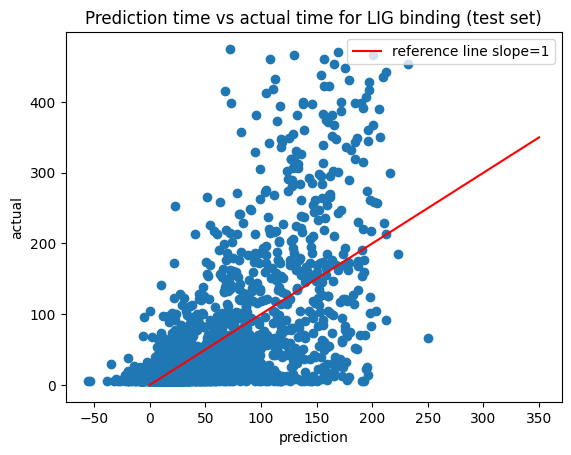

In [259]:
plt.scatter(ap2,al2)
# r=np.corrcoef(ap2[:,0], al2[:,0])
r=np.corrcoef(ap2, al2)
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 350,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("Prediction time vs actual time for LIG binding (test set)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.show()

#just charges averages

r2: 0.7263887013982742


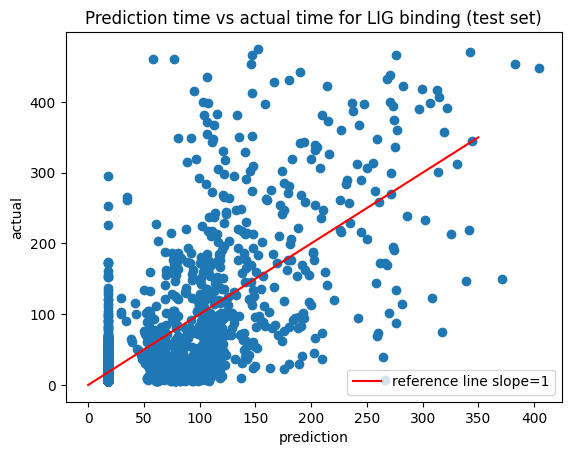

In [268]:
plt.scatter(ap2,al2)
# r=np.corrcoef(ap2[:,0], al2[:,0])
r=np.corrcoef(ap2, al2)
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 350,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("Prediction time vs actual time for LIG binding (test set)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.show()

#just aromatic averages